In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
from scipy.special import softmax as softmax
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from model.cnn import SimpleConv, Trainer

In [3]:
config = {
    'use_cuda': True,
    'batch_size': 128,
    'epochs': 3,
    'lr': 1e-2,
    'momentum': 0.5,
    'seed': 1,
    'log_interval': 10
}



In [4]:
x, y = fetch_openml('mnist_784', return_X_y=True, cache=True)

In [5]:
%%time
x_ood, _ = fetch_openml('Fashion-MNIST', return_X_y=True, cache=True)

CPU times: user 12.4 s, sys: 270 ms, total: 12.7 s
Wall time: 12.7 s


In [6]:
x = x.reshape(-1, 1, 28, 28)
y = y.astype('long').reshape(-1)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=10_000, stratify=y)
x_train /= 255.0
x_val /= 255.0


In [24]:
class MCDUEBald:
    """
    Estimate uncertainty for samples with MCDUE approach
    """
    def __init__(self, net, nn_runs=25, dropout_rate=.5, num_classes=1):
        self.net = net
        self.nn_runs = nn_runs
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes

    def estimate(self, X_pool, *args):
        mcd_realizations = np.zeros((X_pool.shape[0], self.nn_runs, self.num_classes))

        with torch.no_grad():
            for nn_run in range(self.nn_runs):
                prediction = self.net(X_pool, dropout_rate=self.dropout_rate)
                mcd_realizations[:, nn_run] = prediction.to('cpu')
                
        return self._bald(mcd_realizations)

                # mcd_realizations[:, nn_run] = np.ravel(prediction.to('cpu'))
        # return np.ravel(np.std(mcd_realizations, axis=1))
    
    def _bald(self, logits):
        # logits_samples = np.stack(
        #         [model.predict(images) for _ in range(opts.predictions_per_example)],
        #         axis=1)  # shape: [batch_size, num_samples, num_classes]
        probs = softmax(logits, axis=-1).mean(-2)
        probs_entropy = - np.sum(probs * np.log(probs + 1e-10), axis=-1)

        samples = softmax(logits, axis=-1)
        samples_entropy = - np.mean(np.sum(samples * np.log(samples + 1e-10), axis=-1), axis=1)

        confidence = -probs_entropy + samples_entropy + 1
        # confidence[confidence < 0] = 0
        # return confidence
        # return zip(probs_entropy, samples_entropy, confidence)
        return confidence


In [39]:
train_samples = 5000
model = SimpleConv()
trainer = Trainer(model)
trainer.fit(x_train[:train_samples], y_train[:train_samples], epochs=config['epochs'])
accuracy_score(y_val, trainer.predict(x_val))

Train Epoch: 0 [0/5000 (0%)]	Loss: 2.312151
Train Epoch: 1 [0/5000 (0%)]	Loss: 0.729372
Train Epoch: 2 [0/5000 (0%)]	Loss: 0.249479


0.945

In [40]:
estimator = MCDUEBald(trainer, num_classes=10)

In [41]:
estimator.estimate(x_train[:10])

array([0.78388152, 0.77646387, 0.88516392, 0.84221351, 0.91383698,
       0.94196853, 0.89926413, 0.75674646, 0.9768737 , 0.94469614])

In [42]:
confidence_train = estimator.estimate(x_train[:1000])
confidence_val = estimator.estimate(x_val[:1000])
confidence_ood = estimator.estimate(x_train[:1000])

In [43]:
print('train')
print(pd.Series(confidence_train).describe())
print()

print('val')
print(pd.Series(confidence_val).describe())
print()

print('ood')
print(pd.Series(confidence_ood).describe())
print()

train
count    1000.000000
mean        0.865921
std         0.136583
min         0.315536
25%         0.799611
50%         0.915188
75%         0.972598
max         0.999952
dtype: float64

val
count    1000.000000
mean        0.855496
std         0.136754
min         0.300545
25%         0.772838
50%         0.902722
75%         0.967670
max         0.999438
dtype: float64

ood
count    1000.000000
mean        0.866256
std         0.135273
min         0.305761
25%         0.806920
50%         0.913166
75%         0.971934
max         0.999886
dtype: float64



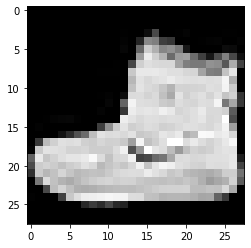

In [22]:
plt.imshow(x_ood[0].reshape((28, 28)), cmap='gray')
plt.show()